# Correlation Between Gene Degree and Predicted Disease Association

This notebook presents the primary results from the manuscript and shows how the degree of a gene in the Hetionet KG correlates with the score, predicted by TransE, for association with four diseases: melanoma, Parkinson's, Fuchs Endothelial Dstrophy and Fallopian tube cancer.

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from pykeen.datasets.hetionet import Hetionet
from scipy import stats

from src.utils import get_predictions_tail

sns.set_theme(style="darkgrid", palette="muted", font_scale=1.5)

## Data Loading

Here we load [Hetionet](http://www.het.io) dataset which is included as part of the PyKEEN package. Note that the random state should match the seed that was used for the dataset when the model was trained. This will ensure train and test edges are correctly labelled.

PyKEEN will download the Hetionet triples into a standard location in a `.data` directory. We load these triples into a dataframe and then into a NetworkX graph to compute the degree of each entity in the graph. If the data is stored in a different location on your system, please change the path in the `.read_csv` function.

In [2]:
data = Hetionet(random_state=42)
data.summarize()  # Summarize the dataset to ensure it is downloaded
# Load the Hetionet edges as downloaded by the PyKEEN dataloader
df: pd.DataFrame = pd.read_csv(
    "~/.data/pykeen/datasets/hetionet/hetionet-v1.0-edges.sif.gz", sep="\t"
)
# Load these edges into a NX graph and compute the degree for each entity
G: nx.MultiGraph = nx.from_pandas_edgelist(
    df, "source", "target", create_using=nx.MultiGraph()
)
degs: dict = dict(G.degree())

Hetionet (create_inverse_triples=False)
Name        Entities    Relations      Triples
----------  ----------  -----------  ---------
Training    45158       24             1800157
Testing     45158       24              225020
Validation  45158       24              225020
Total       -           -              2250197
Head                     Relation    tail
-----------------------  ----------  ------------
Anatomy::UBERON:0000002  AdG         Gene::10005
Anatomy::UBERON:0000002  AdG         Gene::114804
Anatomy::UBERON:0000002  AdG         Gene::118670
Anatomy::UBERON:0000002  AdG         Gene::128989
Anatomy::UBERON:0000002  AdG         Gene::132851



## Model Loading

Here a pretrained model is loaded back into pytorch ready for use in inference. If using a different weight file, please change the path below.

In [3]:
# Load the pretrained model
model = torch.load(
    "./artifacts/transe_hetnet.pkl",
    map_location=torch.device("cpu"),
)

## Plotting Correlation Between Degree and Disease Association

We now use the pretrained model to make predictions and assess the correlation between gene degree and the score assigned by the model for association between gene and disease. 

We first define the diseases we are assessing, we well as the relation type we are querying the model on. This being the Disease->associates->Gene (DaG) relation type.

In [4]:
melanoma: str = "Disease::DOID:1909"
parkinsons: str = "Disease::DOID:14330"
fuchs_endothelial_dstrophy: str = "Disease::DOID:11555"
fallopian_tube_cancer: str = "Disease::DOID:1964"

query_relation: str = "DaG"

We can now query the model by asking it to rank every entity in the graph by how likely it considers each entity to be to correct choice to complete the partial triple Disease->associates->? The function below returns a dataframe of predictions for this partial triple sorted by assigned score.

In [5]:
predictions_df: pd.DataFrame = get_predictions_tail(
    melanoma, query_relation, data, model, degs
)
predictions_df.head()

,tail_id,tail_label,score,in_training,in_testing,entity_type,triple_type,deg
23021,23021,Gene::3569,-2.389650,True,False,Gene,train,774
29634,29634,Gene::7040,-2.431028,False,False,Gene,novel,1188
23818,23818,Gene::3952,-2.485554,False,False,Gene,novel,572
23052,23052,Gene::3600,-2.506621,True,False,Gene,train,389
22188,22188,Gene::301,-2.515852,False,False,Gene,novel,681


In [6]:
def plot_score_degree_all(df: pd.DataFrame, disease: str) -> None:

    plt.figure(figsize=(12, 8))
    ax = sns.scatterplot(
        data=df,
        x="deg",
        y="score",
        hue="entity_type",
        style="entity_type",
        alpha=0.8,
        linewidth=0,
    )
    ax.set(
        xscale="log",
        xlabel="Degree (log)",
        ylabel="Predicted Score",
        title=f"Degree Vs. Score for all Entities: {disease}",
    )
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), title="Entity Type")
    plt.show()

### All Entity Types

As every entity is scored in the prediction phase for the partial triple, we can now plot how the model scores these versus the degree of each entity. The plot below shows this, where each entity has been coloured by its type within the graph. We can see that the model scores all gene entities well above others, which makes sense as only genes are seen complete the DaG triples.

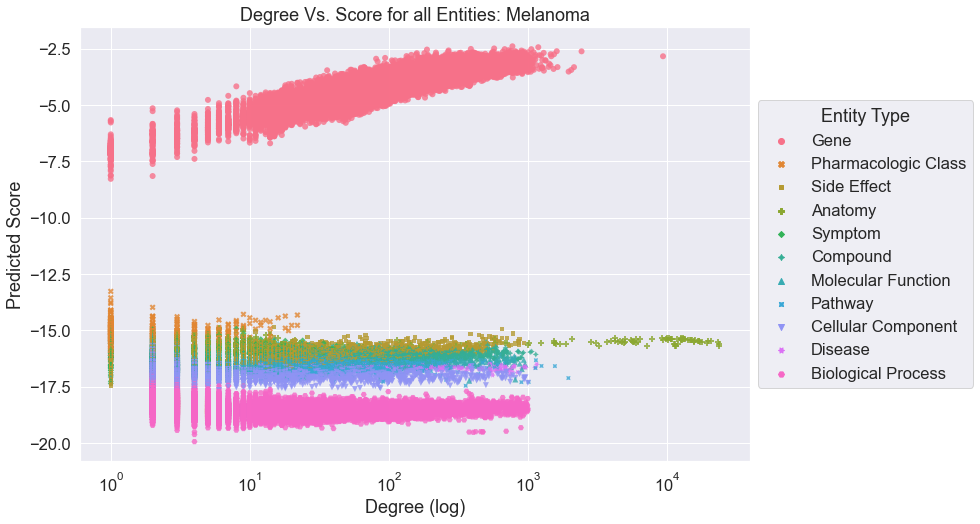

In [7]:
plot_score_degree_all(predictions_df, "Melanoma")

In [8]:
def plot_score_degree_gene(df: pd.DataFrame, disease: str) -> None:
    def annotate(data, **kws):

        _, _, r_value, _, _ = stats.linregress(np.log10(df["deg"]), df["score"])
        ax = plt.gca()
        ax.text(0.05, 0.8, f"$R^2$: {r_value**2:.2f}", transform=ax.transAxes)

    ax = sns.lmplot(
        data=df,
        x="deg",
        y="score",
        hue="triple_type",
        hue_order=["novel", "train", "test"],
        logx=True,
        n_boot=10000,
        seed=0,
        height=6,
        aspect=1.2,
    )
    ax.map_dataframe(annotate)
    ax.set(
        xscale="log",
        xlabel="Degree (log)",
        ylabel="Predicted Score",
        xlim=(0.5, 11000),
        title=f"Degree Vs. Score for Genes: {disease}",
    )
    ax.legend.set_title("Triple Type")
    ax.legend.set_bbox_to_anchor((0.95, 0.5))
    plt.show()

### Gene Degree versus Predicted Score: Melanoma

We can now filter the larger dataframe for just the gene entities and plot the correlation between entity degree and score again for the disease Melanoma. 

This shows there to be a clear correlation between degree and score - the higher the degree, the more likely the model considers the gene to be associated to the disease.

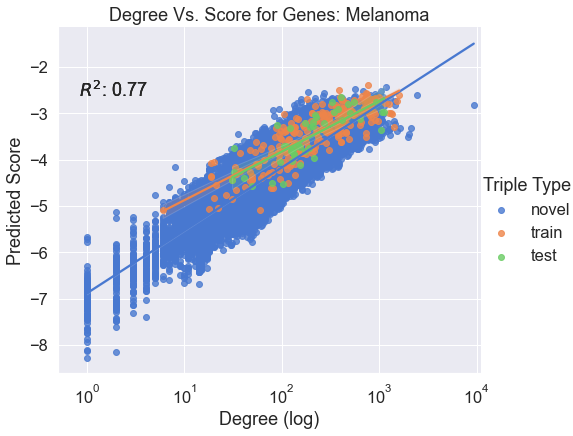

In [9]:
predictions_df: pd.DataFrame = predictions_df[predictions_df.entity_type == "Gene"]
plot_score_degree_gene(predictions_df, "Melanoma")

### Gene Degree versus Predicted Score: Parkinson's

This relationship holds no matter the disease in questions: here we investigate Parkinson's.


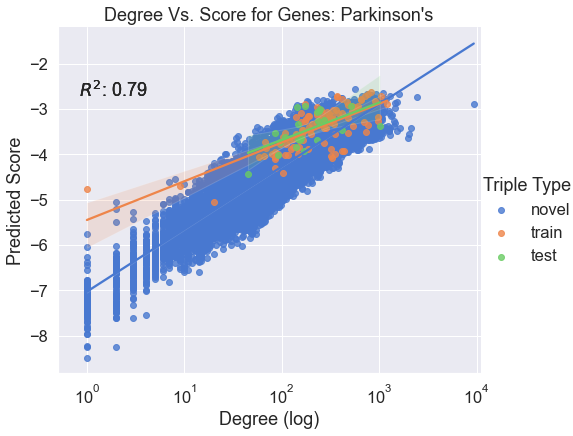

In [10]:
predictions_df: pd.DataFrame = get_predictions_tail(
    parkinsons, query_relation, data, model, degs
)
predictions_df = predictions_df[predictions_df.entity_type == "Gene"]
plot_score_degree_gene(predictions_df, "Parkinson's")

### Gene Degree versus Predicted Score: Fuchs Endothelial Dstrophy

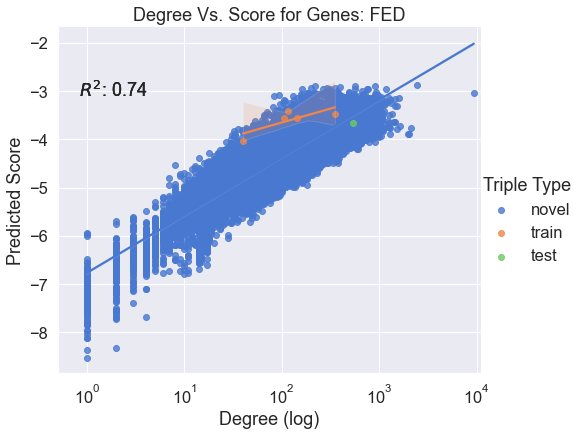

In [11]:
predictions_df: pd.DataFrame = get_predictions_tail(
    fuchs_endothelial_dstrophy, query_relation, data, model, degs
)
predictions_df = predictions_df[predictions_df.entity_type == "Gene"]
plot_score_degree_gene(predictions_df, "FED")

### Gene Degree versus Predicted Score: Fallopian Tube Cancer

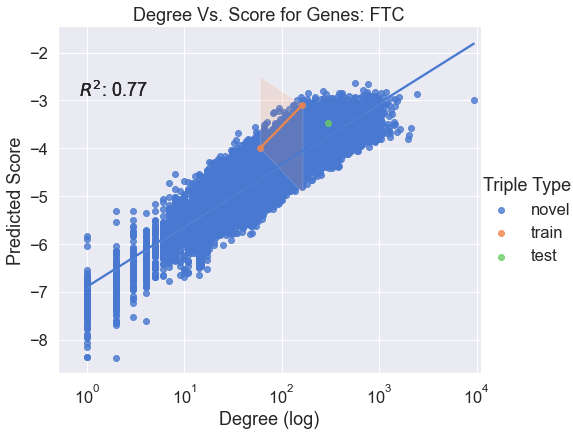

In [12]:
predictions_df: pd.DataFrame = get_predictions_tail(
    fallopian_tube_cancer, query_relation, data, model, degs
)
predictions_df = predictions_df[predictions_df.entity_type == "Gene"]
plot_score_degree_gene(predictions_df, "FTC")